In [ ]:
## Tunes depth profiles of Korolev to each other using dynamic time warping algorithm
## Depth profiles should be .csv files located in ./korolev
## Plots tunings and computes cross-correlation
## Tests XC value against XC's from tunings to random profiles

In [7]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import pandas as pd
import glob
from radarfuncs import *
from DTWfuncs import *
from lmfit.models import SkewedGaussianModel

In [8]:
#Import csv files -- Korolev
csv_importk = glob.glob("data/korolev2/*4zoom.csv")
csv_importk = sorted(csv_importk, key=lambda x: x[-9])

column_names = ['depth', 'value']
x_listk = []
y_listk = []
fit_listk = []

#load data and put into lists
for i in csv_importk:
    csv = pd.read_csv(i, names=column_names, skiprows=2) #skips headers
    
    x = csv.depth.to_list()
    y = csv.value.to_list()
    
    peak = y.index(max(y[0:50])) #finds surface return
    
    x = x[peak+5:]
    y = y[peak+5:]
    
    #convert pixels to meters
    #x = p2m_waterice(x)
    
    x_listk.append(x)
    y_listk.append(y)
    
    ##compute line to fit synthetic data to
    # Skewed Gaussian fit
    model = SkewedGaussianModel()
    params = model.make_params(amplitude=(max(y)), center=min(x)+20, sigma=20, gamma=1.5)
    result = model.fit(y, params, x=x)
    fit = result.best_fit +np.mean(y[-150:]) # prevents fit from damping out all of the noise on right-handed side
    
    fit_listk.append(fit)
    
print(csv_importk)

#Import csv files -- NPLD
csv_importn = glob.glob("data/NPLD/*zoom.csv")
csv_importn = sorted(csv_importn, key=lambda x: int(x[-10]+x[-9]))
csv_importn = csv_importn[3:4]+csv_importn[7:8]

column_names = ['depth', 'value']
x_listn = []
y_listn = []
fit_listn = []

#load data and put into lists
for i in csv_importn:
    csv = pd.read_csv(i, names=column_names, skiprows=2) #skips headers
    
    x = csv.depth.to_list()
    y = csv.value.to_list()
    
    peak = y.index(max(y[0:50])) #finds surface return
    
    x = x[peak+5:]
    y = y[peak+5:]
    
    #convert pixels to meters
    #x = p2m_waterice(x)
    
    x_listn.append(x)
    y_listn.append(y)
    
    ##compute line to fit synthetic data to
    # Skewed Gaussian fit
    model = SkewedGaussianModel()
    params = model.make_params(amplitude=(max(y)), center=min(x)+20, sigma=20, gamma=1.5)
    result = model.fit(y, params, x=x)
    fit = result.best_fit +np.mean(y[-150:]) # prevents fit from damping out all of the noise on right-handed side
    
    fit_listn.append(fit)
    
print(csv_importn)


['data/korolev2/S_00883101_4zoom.csv']
['data/NPLD/S_00429802_04zoom.csv', 'data/NPLD/S_00480901_08zoom.csv']


XC of data/korolev2/S_00883101_4zoom.csv and data/NPLD/S_00429802_04zoom.csv: 0.46198657661669523
Avg XC of data/korolev2/S_00883101_4zoom.csv and 1000 random profiles:0.11129788996964084. 95% threshold:0.24353499308284987
XC of data/korolev2/S_00883101_4zoom.csv and data/NPLD/S_00480901_08zoom.csv: 0.5660172275892451
Avg XC of data/korolev2/S_00883101_4zoom.csv and 1000 random profiles:0.5065056624138776. 95% threshold:0.900070059626276


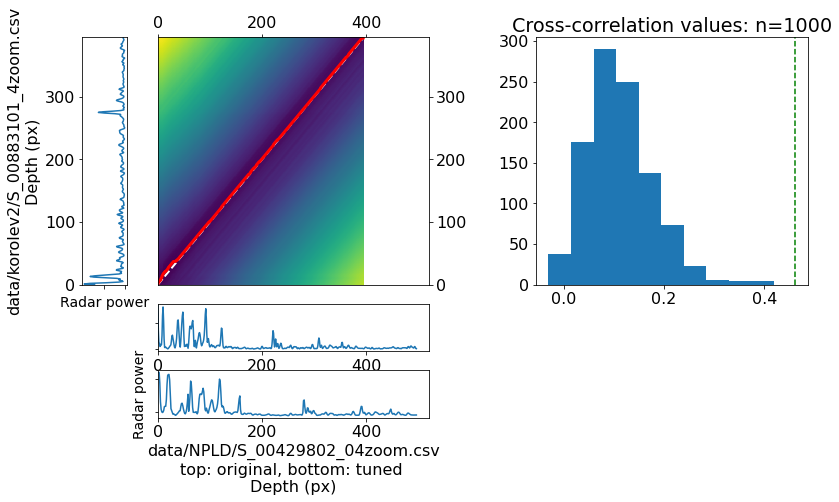

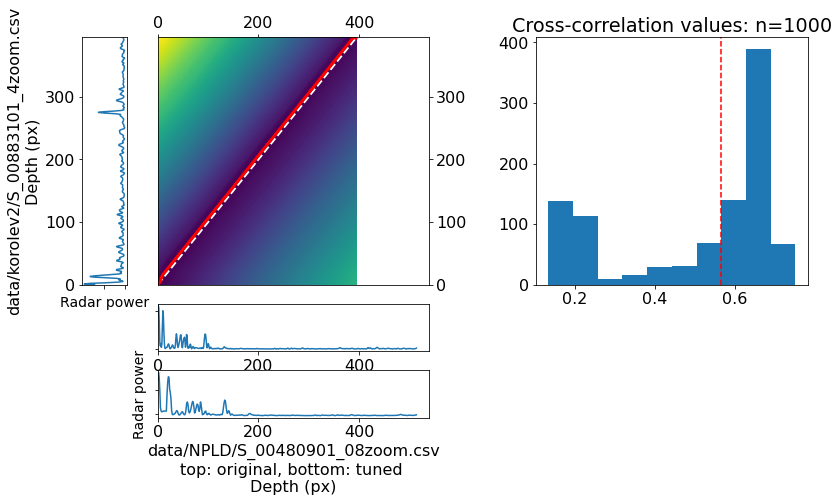

In [9]:
#Use DTW to tune each profile to the other profiles
#plot results, produce XC


for i in range(len(csv_importk)):
    prof1 = csv_importk[i]
    d1 = x_listk[i]
    v1 = y_listk[i]
    fit = fit_listk[i]
    
    for j in range(len(csv_importn)):
        prof2 = csv_importn[j]
        d2 = x_listn[j]
        v2 = y_listn[j]
        fitn = fit_listn[j]
            
        xtune, XC, tstd, dt, W, D, tx = dtw_mars(v1,v2)
        #print(W)
        #np.savetxt('cost_'+str(i)+str(j)+'.csv', D, delimiter=',')
        
        #Run MonteCarlo simulation to assess quality of tunings
        #A strong match is when real XC is nigher than 90% of all XCs from tunings to random profiles

        XC_rs = [] #holds cross correlation values for 1000 random profiles
        syn = []
        #W_rs = []
        
        for a in range(1000):
            r=ar1(d2,v2,fitn) #this creates a random synthetic record with similar properties
            syn.append(r)
            xtune_r, XC_r, tstd_r, dt_r, W_r, D_r, tx_r = dtw_mars(v1,r)
            XC_rs.append(XC_r)
            #W_rs.append(W_r)
            
        #check if correlation is good
        XC_mean = np.mean(XC_rs)
        XC_95 = XC_mean + 2*np.std(XC_rs)
        GoodFit = False
        if XC >= XC_95:
            GoodFit = True
        
        # Set up the axes with gridspec
        plt.rcParams.update({'font.size': 16})
        fig = plt.figure(figsize=(13,7))
        grid = plt.GridSpec(6, 10, hspace=0.4, wspace=0.7)
        main = fig.add_subplot(grid[:-2, 1:5])
        y_prof = fig.add_subplot(grid[:-2, 0], xticklabels=[], sharey=main)
        x_prof = fig.add_subplot(grid[-2, 1:5], yticklabels=[], sharex=main)
        hist = fig.add_subplot(grid[:-2,6:])
        x_tune = fig.add_subplot(grid[-1, 1:5], yticklabels=[], sharex=main)
        

        # DTW min path on main
        main.pcolor(D)
        main.plot([0,len(v1)-1], [0,len(xtune)-1],'w--', linewidth=2)
        main.plot(W[:,1], W[:,0],'r-', linewidth=3)
        main.xaxis.tick_top()
        main.yaxis.tick_right()

        # x profile -- what gets tuned
        xax= np.subtract(d2,d2[0])
        x_prof.plot(xax, v2)
        #x_prof.set_xlabel(prof2)
        #x_prof.set_ylabel("Radar power")

        #y profile -- fixed
        yax = np.subtract(d1,d1[0])
        y_prof.plot(np.multiply(-1,v1),yax)
        y_prof.set_ylabel(prof1 + "\nDepth (px)")
        y_prof.set_xlabel("Radar power", fontsize = 14)
        
        #X profile -- tuned
        xax= np.subtract(tx,tx[0])
        x_tune.plot(xax, xtune)
        x_tune.set_xlabel(prof2 + "\ntop: original, bottom: tuned \nDepth (px)")
        x_tune.set_ylabel("Radar power", fontsize = 14)
    
        # histogram of XC values
        hist.hist(XC_rs) #bins = n_bins
        hist.set_title("Cross-correlation values: n="+str(len(XC_rs)))
        if GoodFit == False:
            hist.axvline(x = XC, color = 'r', ls='--')
        else:
            hist.axvline(x = XC, color = 'g', ls = '--')
        
        fig.savefig("K"+str(i+1)+"N"+str(j+1)+".png")
        
        print("XC of "+prof1+" and "+prof2+": "+str(XC))
        print("Avg XC of "+prof1+ " and 1000 random profiles:"+str(XC_mean)+ ". 95% threshold:"+str(XC_95))


In [ ]:
# Set up the axes with gridspec
# plt.rcParams.update({'font.size': 16})
# fig = plt.figure(figsize=(13,7))
# grid = plt.GridSpec(6, 10, hspace=0.8, wspace=1.4)
# main = fig.add_subplot(grid[:-2, 1:5])
# y_prof = fig.add_subplot(grid[:-2, 0], xticklabels=[], sharey=main)
# x_prof = fig.add_subplot(grid[-2, 1:5], yticklabels=[], sharex=main)
# hist = fig.add_subplot(grid[:-2,6:])
# x_tune = fig.add_subplot(grid[-1, 1:5], yticklabels=[], sharex=main)
# #x_prof.set_xlabel("korolev1234567_1zoom")
# x_tune.set_xlabel("korolev1234567_1zoom \ntop: original, bottom: tuned \nDepth (px)")
# y_prof.set_xlabel("Radar power", fontsize = 14)
# x_tune.set_ylabel("Radar power", fontsize = 14)

# hist.set_title("Cross-correlation values:")
